In [1]:
import pandas as pd
import numpy as np
import time
import random
import lightgbm as lgb
import time
import gc
import pickle
import matplotlib.pyplot as plt

In [2]:
from process import type_score

In [3]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [4]:
DATA_DATE = '20190721'
VER = '02'
MAP_DATE = '20190728'
MODEL_DATE = '20190804'
num_rep = 3

In [5]:
# input files
mols_split = OUTPUT + DATA_DATE + '_' + 'molecule_name_split.pickle'
features_train = OUTPUT + MODEL_DATE + '_' + VER + '_' + 'features_train_{}.pickle'
features_test = OUTPUT + MODEL_DATE + '_' + VER + '_' + 'features_test_{}.pickle'

In [6]:
# output files
trained_models = OUTPUT + MAP_DATE + '_' + VER + '_' + 'champs_models_lgb_{}_{}.pickle'

In [7]:
bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']

with open(mols_split, 'rb') as f:
    mols_train = pickle.load(f)
    mols_val =  pickle.load(f)

In [8]:
rounds = 20000
params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l1'},
        'num_leaves' : 15,
        'learning_rate' : 0.1,
        'feature_fraction' : 0.7,
    'seed':0
}

---------- 3JHN ----------
7833
score first model(train): 0.35
score second model(train): -2.78
score first model(val): 0.14
score second model(val): -2.00


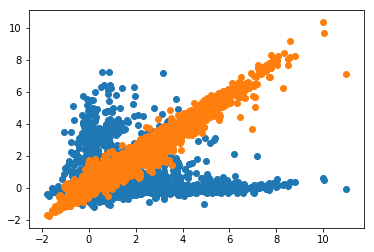

elapsed_time:95.31[sec]
---------- 3JHC ----------
20000
score first model(train): 1.28
score second model(train): -1.42
score first model(val): 1.27
score second model(val): -1.16


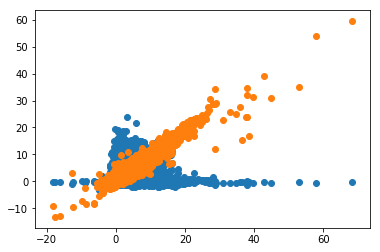

elapsed_time:1963.94[sec]
---------- 1JHC ----------
20000
score first model(train): 2.70
score second model(train): -1.05
score first model(val): 2.92
score second model(val): -0.55


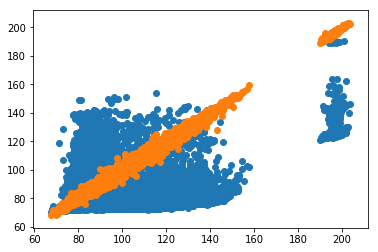

elapsed_time:890.98[sec]
---------- 2JHH ----------
10967
score first model(train): 1.40
score second model(train): -2.49
score first model(val): 2.11
score second model(val): -1.92


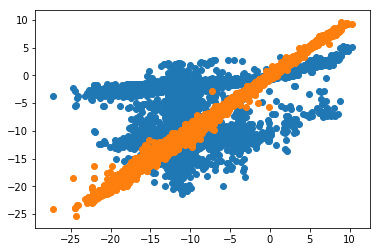

elapsed_time:276.39[sec]
---------- 1JHN ----------
1965
score first model(train): 2.29
score second model(train): -1.82
score first model(val): 2.63
score second model(val): -1.12


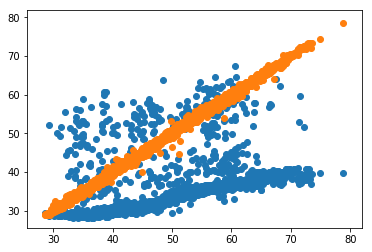

elapsed_time:10.39[sec]
---------- 2JHN ----------
4163
score first model(train): 1.16
score second model(train): -2.21
score first model(val): 0.94
score second model(val): -1.62


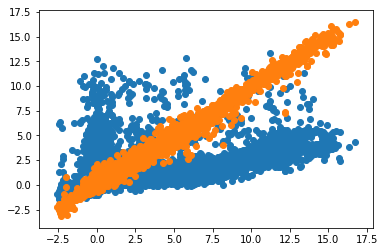

elapsed_time:42.66[sec]
---------- 2JHC ----------
13567
score first model(train): 1.33
score second model(train): -1.43
score first model(val): 1.05
score second model(val): -1.18


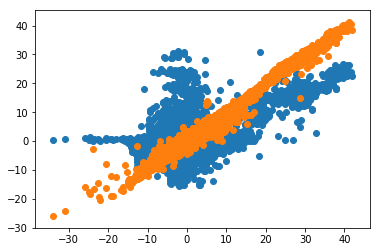

elapsed_time:997.11[sec]
---------- 3JHH ----------
20000
score first model(train): 1.40
score second model(train): -2.50
score first model(val): 1.44
score second model(val): -1.88


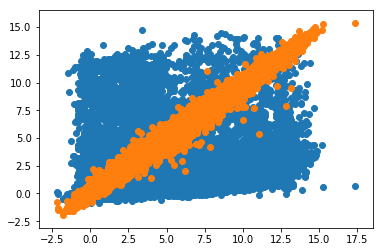

elapsed_time:737.85[sec]


In [9]:
scores = []
for b in bond_types:
    print('-'*10, b, '-'*10)
    start = time.time()
    
    df = pd.read_pickle(features_train.format(b)).fillna(0)
    
    df_train = df[df['molecule_name'].isin(mols_train)]    
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    lgb_train = lgb.Dataset(X_train, y_train)
    
    df_val = df[df['molecule_name'].isin(mols_val)]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=rounds,
            verbose_eval=0,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
    
    with open(trained_models.format(b, num_rep), 'wb') as f:
        pickle.dump(gbm, f)
    
    y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)

    score_first_train = type_score(y_train, X_train[:, -98])
    score_second_train = type_score(y_train, y_train_pred)
    
    score_first = type_score(y_val, X_val[:, -98])
    score_second = type_score(y_val, y_val_pred)
    scores.append(score_second)
    print(gbm.best_iteration)
    print("score first model(train): %.2f" %  (score_first_train))
    print("score second model(train): %.2f" %  (score_second_train))
    print("score first model(val): %.2f" %  (score_first))
    print("score second model(val): %.2f" %  (score_second))
    plt.scatter(y_val, X_val[:, -98])
    plt.scatter(y_val, y_val_pred)
    plt.show()
    elapsed_time = time.time() - start
    print ("elapsed_time:%.2f" % elapsed_time + "[sec]")


In [10]:
print('type score:', scores)
print('total score:', np.array(scores).mean())

# bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']
# type score: [-2.213330811075121, -1.3581258350105094, -0.7845050130296711, -2.1655013094988513, -1.4024121799402647, -1.9751865470643377, -1.499394936229838, -2.1188348800106724]
# total score: -1.689661438982408

# type score: [-2.28902398311401, -1.4791095387178295, -0.7890149359865372, -2.1723545614441644, -1.4082551775248713, -2.006690196641646, -1.5725220365355648, -2.1540960045133906]
# total score: -1.7338833043097517

# type score: [-2.0427341664896064, -1.2762031053561742, -0.6178972968565161, -1.912917007478421, -1.2255351667016632, -1.7629011333121432, -1.389777406449362, -1.9160328230712362]
# total score: -1.5179997632143905

# type score: [-1.9101332655356675, -1.1628418118901607, -0.5434521045759116, -1.9613443727002142, -1.0990378130713154, -1.6574200950077103, -1.2592226175573524, -1.8295375254557389]
# total score: -1.4278737007242588

# type score: [-2.0331017886553004, -1.3198176846679164, -0.5832207930819349, -1.9679299437760127, -1.1593540329311445, -1.7702498450448798, -1.405502727973874, -1.9428615568986836]
# total score: -1.5227547966287185

type score: [-1.9958364323152584, -1.1625353096467472, -0.5490930265190621, -1.9233944531932545, -1.1215715014742833, -1.6215290555060744, -1.1834664928677456, -1.884981222846708]
total score: -1.430300936796142
